In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from character.constants import DATA_PATH, FIGURE_PATH

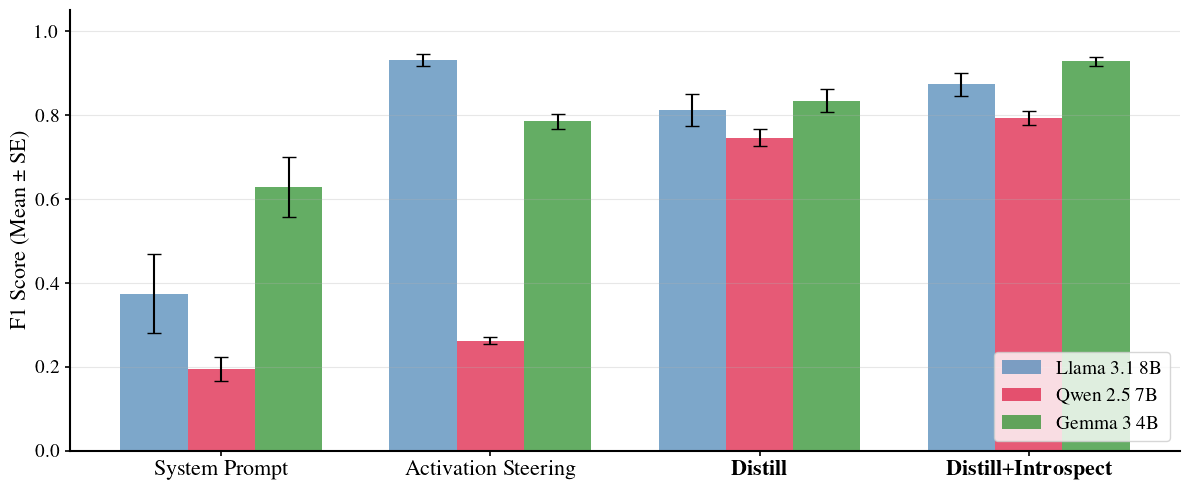

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage[T1]{fontenc}\usepackage{newtxtext,newtxmath}",
})

# Combined plot merging results from Llama and Qwen and Gemma

plt.figure(figsize=(12, 5))

# Load data for all three models
PATH_LLAMA = f"{DATA_PATH}/robustness/llama-3.1-8b-it"
f1_llama = pd.read_json(f"{PATH_LLAMA}/f1.jsonl", orient="records", lines=True)
filtered_f1_llama = f1_llama[~f1_llama["variant"].isin(["default", "all"])].copy()
filtered_f1_llama.loc[:, 'model'] = 'Llama 3.1 8B'

PATH_QWEN = f"{DATA_PATH}/robustness/qwen-2.5-7b-it"
f1_qwen = pd.read_json(f"{PATH_QWEN}/f1.jsonl", orient="records", lines=True)
filtered_f1_qwen = f1_qwen[~f1_qwen["variant"].isin(["default", "all"])].copy()
filtered_f1_qwen.loc[:, 'model'] = 'Qwen 2.5 7B'

PATH_GEMMA = f"{DATA_PATH}/robustness/gemma-3-4b-it"
f1_gemma = pd.read_json(f"{PATH_GEMMA}/f1.jsonl", orient="records", lines=True)
filtered_f1_gemma = f1_gemma[~f1_gemma["variant"].isin(["default", "all"])].copy()
filtered_f1_gemma.loc[:, 'model'] = 'Gemma 3 4B'

# Combine data from all three models
combined_f1 = pd.concat([filtered_f1_llama, filtered_f1_qwen, filtered_f1_gemma], ignore_index=True)

# Calculate mean and standard error for each method and model
summary_stats = combined_f1.groupby(['method', 'model'])['score'].agg(['mean', 'sem']).reset_index()

methods = ['prompted', 'steered', 'trained_distillation', 'trained_introspection']
method_labels = ['System Prompt', 'Activation Steering', r'\textbf{Distill}', r'\textbf{Distill$+$Introspect}']
models = ['Llama 3.1 8B', 'Qwen 2.5 7B', 'Gemma 3 4B']
colors = ['steelblue', 'crimson', 'forestgreen']

# Set up bar positions
x = np.arange(len(methods))
width = 0.25

# Create bars for each model
for i, model in enumerate(models):
    model_data = summary_stats[summary_stats['model'] == model]
    means = [model_data[model_data['method'] == method]['mean'].iloc[0] if len(model_data[model_data['method'] == method]) > 0 else 0 for method in methods]
    sems = [model_data[model_data['method'] == method]['sem'].iloc[0] if len(model_data[model_data['method'] == method]) > 0 else 0 for method in methods]
    
    plt.bar(x + i * width, means, width, label=model, color=colors[i], alpha=0.7, 
            yerr=sems, capsize=5, error_kw={'linewidth': 1.5})

plt.ylim(0, 1.05)
# plt.xlabel('Method of Altering Persona', fontsize=16)
plt.ylabel('F1 Score (Mean ± SE)', fontsize=16, weight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Set x-tick labels
plt.xticks(x + width, method_labels, fontsize=16, weight='bold')
ax = plt.gca()

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make remaining spines thicker and darker
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.tick_params(axis='y', labelsize=14, width=1.2, colors='black')
plt.tick_params(axis='x', width=1.2, colors='black')
plt.legend(fontsize=14, loc='lower right')
plt.tight_layout()
outpath = f"{FIGURE_PATH}/robustness.png"
os.makedirs(os.path.dirname(outpath), exist_ok=True)
plt.savefig(outpath, dpi=400)
plt.show()